In [ ]:
from __future__ import print_function

import matplotlib.pyplot as plt
import skimage
from skimage import io

import cv2 as cv
import numpy as np
from scipy import ndimage

In [ ]:
# Utils

# Show an image
def showImage(title, X, is_gray=False) :
  print(title)
  plt.figure(figsize=(10, 10))
  if is_gray:
    plt.imshow(X, 'gray')
  else:
    plt.imshow(X)
  plt.show()


# Classify a cell according to RGB rate
def isBlueCell(r, g, b):
  # Heuristic: if there is more blue -> it's a Blue cell
  # Otherwise it's a brown one
  return b > r

Input image


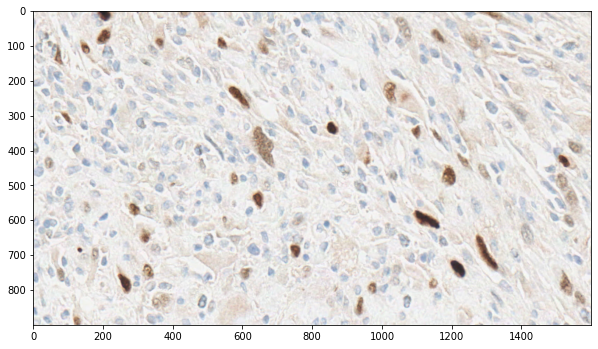

In [ ]:
image_url = ('https://data.kitware.com/api/v1/file/598b71ee8d777f7d33e9c1d4/download')  # DAB.png

im_input = skimage.io.imread(image_url)

showImage('Input image', im_input)

Input image 3 channels --- (900, 1600, 3)


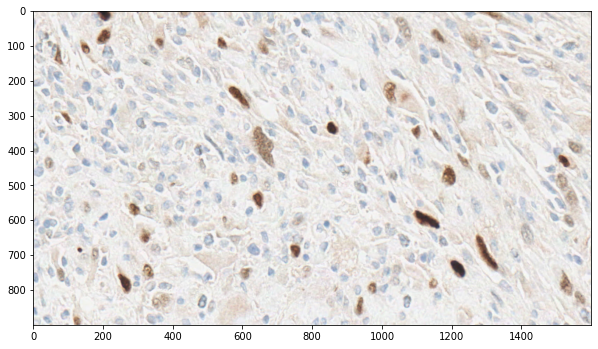

In [ ]:
# Work with first 3 channels as RGB
img = im_input[:, :, :3]

showImage(f'Input image 3 channels --- {img.shape}', img)

Gray scale image


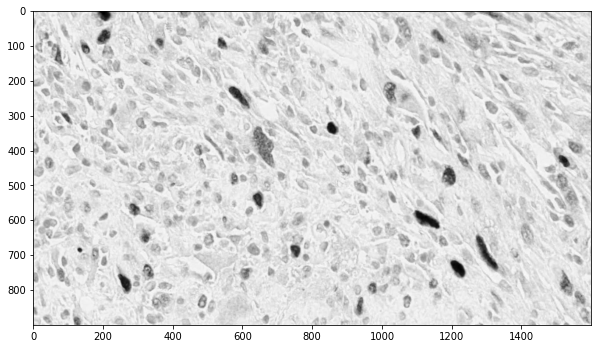

In [ ]:
# Gray scale using OPEN CV
img_gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
showImage('Gray scale image', img_gray, 'gray')

Cell segmentation


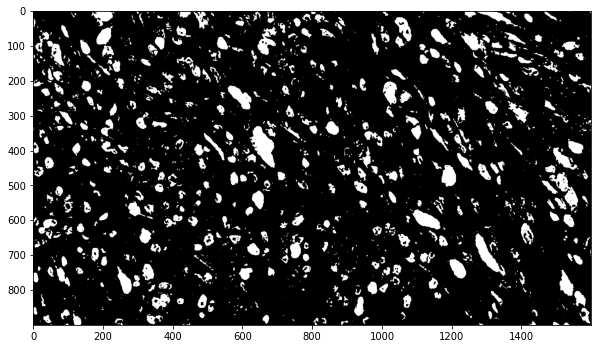

In [ ]:
# Thresholding cells
ret, thresh = cv.threshold(img_gray,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
showImage('Cell segmentation', thresh, True)

In [ ]:
# Binarization output and labelization
cells = thresh.copy()
cells[cells > 0] = 1

components, n_component = ndimage.label(cells)

print(f"{n_component} components found.")

1780 components found.


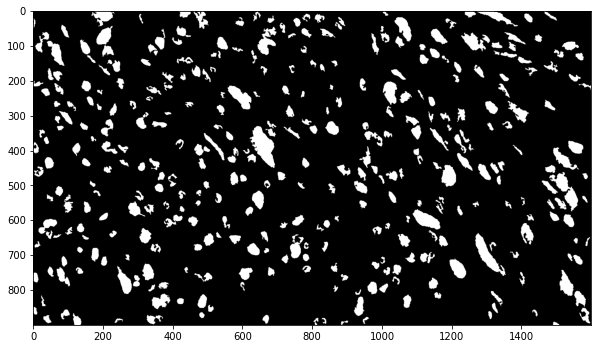

1420 components removed.
360 components found.


In [ ]:
# Remove tiny components
n_removed = 0
unique, counts = np.unique(components, return_counts=True)
for i, nb in zip(unique, counts):
  if nb < 100:
    components[components == i] = 0
    n_removed += 1

# Filling holes using opening morphological operation
components = ndimage.morphology.binary_fill_holes(components > 0)

# Relabelize components
components, n_component = ndimage.label(components)

showImage('', components > 0, True)

print(f"{n_removed} components removed.")
print(f"{n_component} components found.")

Input image


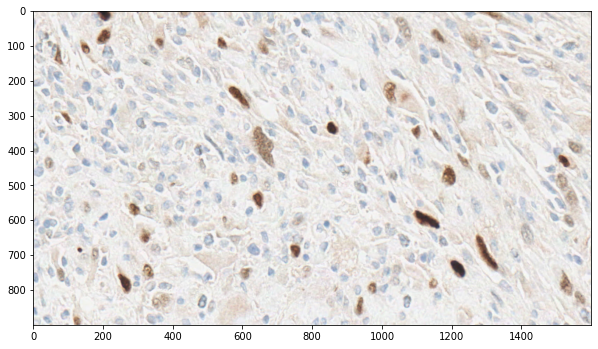

Classification: 262 blue -- 97 brown cells


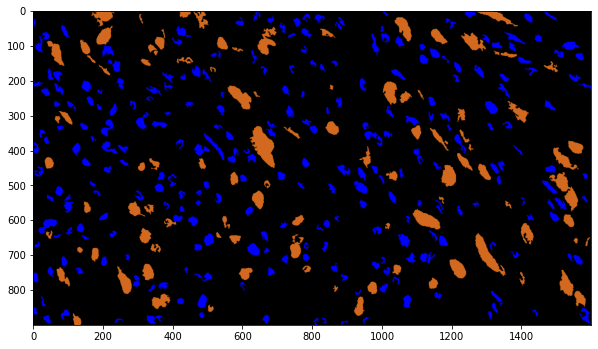

In [ ]:
candidates = np.zeros_like(img)

n_blue, n_brown = 0, 0

# For each cells: use the heuristic to classify blue or brown
for icomp in range(1, n_component):
  j, i = np.where(components == icomp)
  n_pixels_component = len(j)
  r_mean, b_mean = 0.0, 0.0
  for y, x in zip(j, i):
    r_mean += img[y, x, 0]
    b_mean += img[y, x, 2]
  r_mean /= n_pixels_component
  b_mean /= n_pixels_component

  if isBlueCell(r_mean, 0, b_mean):
    candidates[:, :, 2][components == icomp] = 255
    n_blue += 1
  else:
    candidates[:, :, 0][components == icomp] = 210
    candidates[:, :, 1][components == icomp] = 105
    candidates[:, :, 2][components == icomp] = 30
    n_brown += 1

showImage('Input image', im_input)
showImage(f'Classification: {n_blue} blue -- {n_brown} brown cells', candidates)